# Tutorial to use the harmonic Metropolis-Hastings sampling

This tutorial describe how to use the harmonic domain implementation of the method, as described in [Leloup et al. 2023](https://arxiv.org/abs/2308.03412).

In [1]:
import os, sys, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import jax
import jax.numpy as jnp
from fgbuster import get_instrument, get_observation, get_noise_realization

import micmac

First, define the problem you want to solve

In [2]:
fgs_model = 'd0s0' # Defining the foreground model

# In case you want to use the customized routines, proceeds as follows 
# you must then define fgs_model_init for the original model from PySM (here with d7s1 as an example) 
# and nside_spv_model for the chosen spatial variatibility of the SEDs 
if fgs_model == 'customized_nonparametric' or fgs_model == 'customized_parametric':
    fgs_model_init = ['s1','d7']
    nside_spv_model = 1
    idx_ref_freq = 6 # Index of the reference frequency in the PySM model ; 6 for 93 GHz in the example of LiteBIRD as it corresponds to the 7th frequency channel


noise_seed = 42 # Define the seed for the noise realization
seed_realization_CMB = 43 # Define the seed for the CMB realization

Then, identify the directories for the param files

In [3]:
dir_params = "example_params/"

# The toml file contain the main parameters for the proper initiliazation of the pipeline
param_toml = dir_params + "corr_fullsky_LB_Harmonic.toml" 
# The yaml file contain spatial variability parameters which are not relevant here, but are needed for the pipeline to run and essential for the pixel pipeline
param_spv_yaml = dir_params + "params_spv_LB_nside0.yaml" 

Afterwards, create the harmonic sampler from the param files

In [4]:
Harm_obj = micmac.create_Harmonic_MICMAC_sampler_from_toml_file(param_toml, param_spv_yaml)

<_io.TextIOWrapper name='example_params/params_spv_LB_nside0.yaml' mode='r' encoding='UTF-8'>
count_b: 26
n_betas:  26

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
      b5
        default: None
      b6
        default: None
      b7
        default: None
      b8
        default: None
      b9
        default: None
      b10
        default: None
      b11
        default: None
      b12
        default: None
    f2
      default: [0]
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
      b5
        default: None
      b6
        default: None
      b7
        default: None
      b8
        default: None
      b9
        default: None
      b10
        default: None

Note that the object `Harm_obj` can also be created from `MICMAC_Sampler`.

# Generate input maps

Defining the parameters of the problem using **`fgbuster`**

In [5]:
instr_name = Harm_obj.instrument_name

# Define the instrument
if Harm_obj.instrument_name != 'customized_instrument':
    instrument = get_instrument(Harm_obj.instrument_name) # To get the
else:
    with open(path_toml_file) as f:
        dictionary_toml = toml.load(f)
    f.close()
    instrument = micmac.get_instr(Harm_obj.frequency_array, dictionary_toml['depth_p'])

# Get input foreground maps

if fgs_model == 'customized_parametric':
    print(f"Taking customized parametric foreground model {fgs_model_init} downgraded to {nside_spv_model}")
    my_sky, _ = micmac.parametric_sky_customized(
        fgs_model_init, 
        Harm_obj.nside, 
        nside_spv_model
    )
    freq_maps_fgs_denoised = micmac.get_observation_customized(
        instrument, 
        my_sky, 
        nside=Harm_obj.nside, 
        noise=False
    )[:, 1:, :]   # keep only Q and U
elif fgs_model == 'customized_nonparametric':
    print(f"Taking customized nonparametric foreground model {fgs_model_init} downgraded to {nside_spv_model}")
    freq_maps_fgs_denoised, non_param_fgs_SEDs = micmac.fgs_freq_maps_from_customized_model_nonparam(
        Harm_obj.nside, 
        nside_spv_model, 
        instrument, 
        fgs_models=fgs_model_init, 
        idx_ref_freq=idx_ref_freq
        )
elif fgs_model != '':
    print(f"Taking PySM foreground model {fgs_model}")
    freq_maps_fgs_denoised = get_observation(
        instrument, 
        fgs_model, 
        nside=Harm_obj.nside, 
        noise=False
        )[:, 1:, :]  # keep only Q and U
else:
    print("No foreground model specified")
    freq_maps_fgs_denoised = np.zeros((Harm_obj.n_frequencies, Harm_obj.nstokes, Harm_obj.n_pix)) # No foregrounds


Taking PySM foreground model d0s0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# Get noise maps
np.random.seed(noise_seed)
input_noise_map = get_noise_realization(Harm_obj.nside, instrument)[:, 1:, :]

Assemble everything

In [7]:
freq_maps_fgs = freq_maps_fgs_denoised + input_noise_map


Now retrieving the CMB maps and spectra using the r value given in the params files using `CAMB` to generate an input CMB spectrum and `Healpy` to generate the map

In [8]:
np.random.seed(seed_realization_CMB)

input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = Harm_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


- `input_freq_maps` contains CMB+foregrounds+noise
- `input_cmb_maps` only contains CMB (over all frequencies)
- `theoretical_red_cov_r0_total` is the scalar mode spectrum given with dimensions `[lmax+1-lmin, nstokes, nstokes]`
- `theoretical_red_cov_r1_tensor` is the tensor mode spectrum given with dimensions `[lmax+1-lmin, nstokes, nstokes]`

To recover the classic form of the power specturm `[number_correlations,lmax+1-lmin]` from the reduced covariance form with dimensions `[lmax+1-lmin, nstokes, nstokes]`, we can call:

In [9]:
theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

The input covariance can be retrieved as:

In [10]:
input_cmb_power_spectrum = theoretical_r0_total + theoretical_r1_tensor * Harm_obj.r_true

## Minimally informed approach

In order to do the minimally informed approach described in [Leloup et al. 2023](https://arxiv.org/abs/2308.03412), we must define a correction term denoted `C_approx`.

In the approach, this can correspond to the scalar mode power spectrum, so we can define it as:

In [11]:
c_ell_approx = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

From here, we have almost all the tools to compute the log-proba associated with the problem, we now need to set up the sampling itself.

# First guesses and covariance for the Metropolis-Hastings sampling

We can obtain the B_f covariance and r step-size through Fisher matrices computed prior

In [12]:
ls examples_Fisher_matrices/

Fisher_matrix_LiteBIRD_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt
Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt


In [13]:
dir_Fisher = 'examples_Fisher_matrices/'

inverse_covariance_matrix = np.loadtxt(dir_Fisher + 'Fisher_matrix_LiteBIRD_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')

covariance_B_f = np.linalg.inv(inverse_covariance_matrix)[:-1, :-1]/100
step_size_r = np.sqrt(np.linalg.inv(inverse_covariance_matrix)[-1, -1])/1

We can compute the exact solutions for $B_f$ (with *d0s0*) from a given parametrisation with $\beta_d$, $T_d$, $\beta_s$

In [14]:
exact_solution_beta_mbb = 1.54
exact_solution_temp_mbb = 20.
exact_solution_beta_pl = -3.

In [15]:
if fgs_model == 'customized_nonparametric':
    init_mixing_matrix_obj = micmac.InitMixingMatrix(
        freqs=Harm_obj.frequency_array,
        ncomp=Harm_obj.n_components,
        pos_special_freqs=Harm_obj.pos_special_freqs,
        spv_nodes_b=Harm_obj.spv_nodes_b,
        non_param_fgs_mixing_matrix=non_param_fgs_SEDs,
        beta_mbb=exact_solution_beta_mbb,
        temp_mbb=exact_solution_temp_mbb,
        beta_pl=exact_solution_beta_pl
    )
    theoretical_params = init_mixing_matrix_obj.init_params()
else:
    init_mixing_matrix_obj = micmac.InitMixingMatrix(
        freqs=Harm_obj.frequency_array,
        ncomp=Harm_obj.n_components,
        pos_special_freqs=Harm_obj.pos_special_freqs,
        spv_nodes_b=Harm_obj.spv_nodes_b,
        beta_mbb=exact_solution_beta_mbb,
        temp_mbb=exact_solution_temp_mbb,
        beta_pl=exact_solution_beta_pl
    )
    theoretical_params = init_mixing_matrix_obj.init_params()


>>> init params built with spectral params: 1.54 20.0 -3.0


And then the first guess:

In [16]:
step_size_B_f = np.diag(sp.linalg.sqrtm(covariance_B_f))

gap_to_true_value = 20

init_params_mixing_matrix = theoretical_params + step_size_B_f * gap_to_true_value * np.random.randn(theoretical_params.size)

As for r, it can be anything sensible (between $0$ and the current constraint, but not $0$)

In [17]:
initial_guess_r = 1e-8

The usual approach when considering $r_{\rm true} = 0$ is to set-up a boundary for the $r$ sampling, which is done in the following way

In [18]:
# Getting r_min

## We first define the minimum value of r available to keep C(r) positive definite
r_min = -np.min(theoretical_red_cov_r0_total[:,1,1]/theoretical_red_cov_r1_tensor[:,1,1]) 
Harm_obj.boundary_B_f_r = Harm_obj.boundary_B_f_r.at[0,-1].set(r_min)

***We are now fully ready to perform the Harmonic Metropolis-Hastings sampling !***

# Metropolis-Hastings sampling

As we have loaded from a file the covariance matrix, we can change it by setting the corresponding attribute to Harm_obj

In [19]:
Harm_obj.covariance_B_f = covariance_B_f
Harm_obj.step_size_r = step_size_r

Or we can set it up as the variable `covariance_B_f_r` to pass to `perform_harmonic_MH`

In [20]:
covariance_B_f_r = np.zeros((covariance_B_f.shape[0] + 1, covariance_B_f.shape[1] + 1))
covariance_B_f_r[:-1, :-1] = covariance_B_f
covariance_B_f_r[-1, -1] = step_size_r**2

We can change here the number of iterations of the Metropolis-Hastings, otherwise the one by default in the parameter file will be chosen

In [21]:
Harm_obj.number_iterations_sampling = 30000

Then we can run the sampling itself

In [22]:
Harm_obj.perform_harmonic_MH(input_freq_maps, 
                             c_ell_approx, 
                             init_params_mixing_matrix, 
                             initial_guess_r=initial_guess_r,
                             theoretical_r0_total=theoretical_r0_total, 
                             theoretical_r1_tensor=theoretical_r1_tensor,
                             covariance_B_f_r=None,
                             print_bool=False)

# Beware: the time displayed on the bar might be wrong and the actual time longer !!

Disabling chex !!!
Starting 30000 iterations for harmonic run


sample: 100%|██████████| 30000/30000 [1:48:30<00:00,  4.61it/s]  


End of MH iterations for harmonic run in 108.51840004523595 minutes !


We can then retrieve the chains, which will be in the format [number_iterations+1, size_sample]

In [23]:
all_params_mixing_matrix_samples = Harm_obj.all_params_mixing_matrix_samples
all_r_samples = Harm_obj.all_samples_r

And finally plot the parameters, starting with $r$:

In [24]:
expected_burn_in = 50 # To be fine-tuned

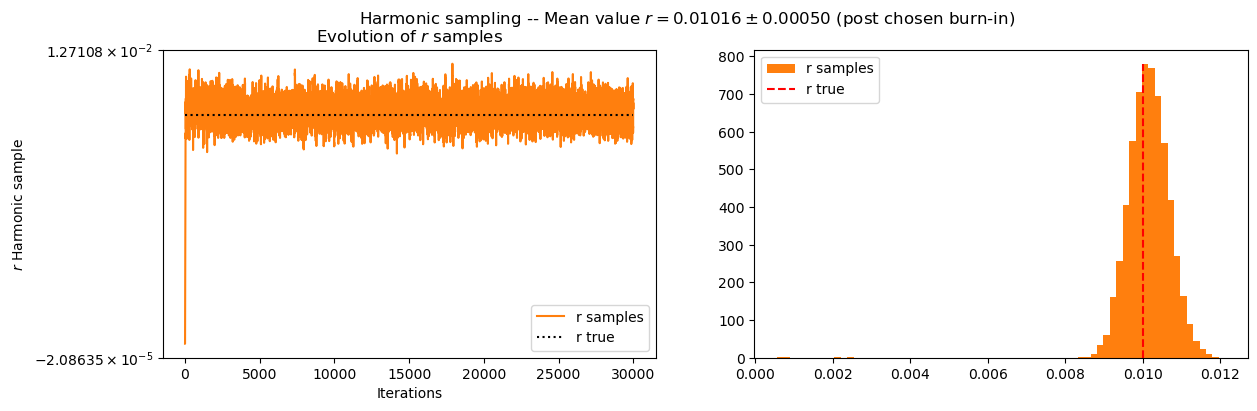

In [34]:
plt.figure(figsize=(14,4))

# n_sigma = 3

all_r_samples = Harm_obj.all_samples_r

cond = np.arange(Harm_obj.number_iterations_sampling) > expected_burn_in
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'blue', 'red', 'gold', 'brown']

plt.suptitle("Harmonic sampling -- Mean value $r = {:.5f} \pm {:.5f}$ (post chosen burn-in) ".format(mean_r, std_r))

plt.subplot(121)
plt.plot(np.arange(Harm_obj.number_iterations_sampling), all_r_samples, color='tab:orange', label='r samples')
plt.plot([0, Harm_obj.number_iterations_sampling], [Harm_obj.r_true,Harm_obj.r_true], 'k:', label='r true')


plt.xlabel("Iterations")
plt.ylabel('$r$ Harmonic sample')
plt.title(r'Evolution of $r$ samples')
if Harm_obj.r_true >= 0:
    plt.yscale('symlog')
else:
    plt.yscale('log')
plt.legend()

plt.subplot(122)
hist_values, bins_value, _ = plt.hist(all_r_samples, bins=70, label='r samples', color='tab:orange', density=True)
plt.plot([Harm_obj.r_true,Harm_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
plt.legend()
plt.show()

Then $\bf B_f$

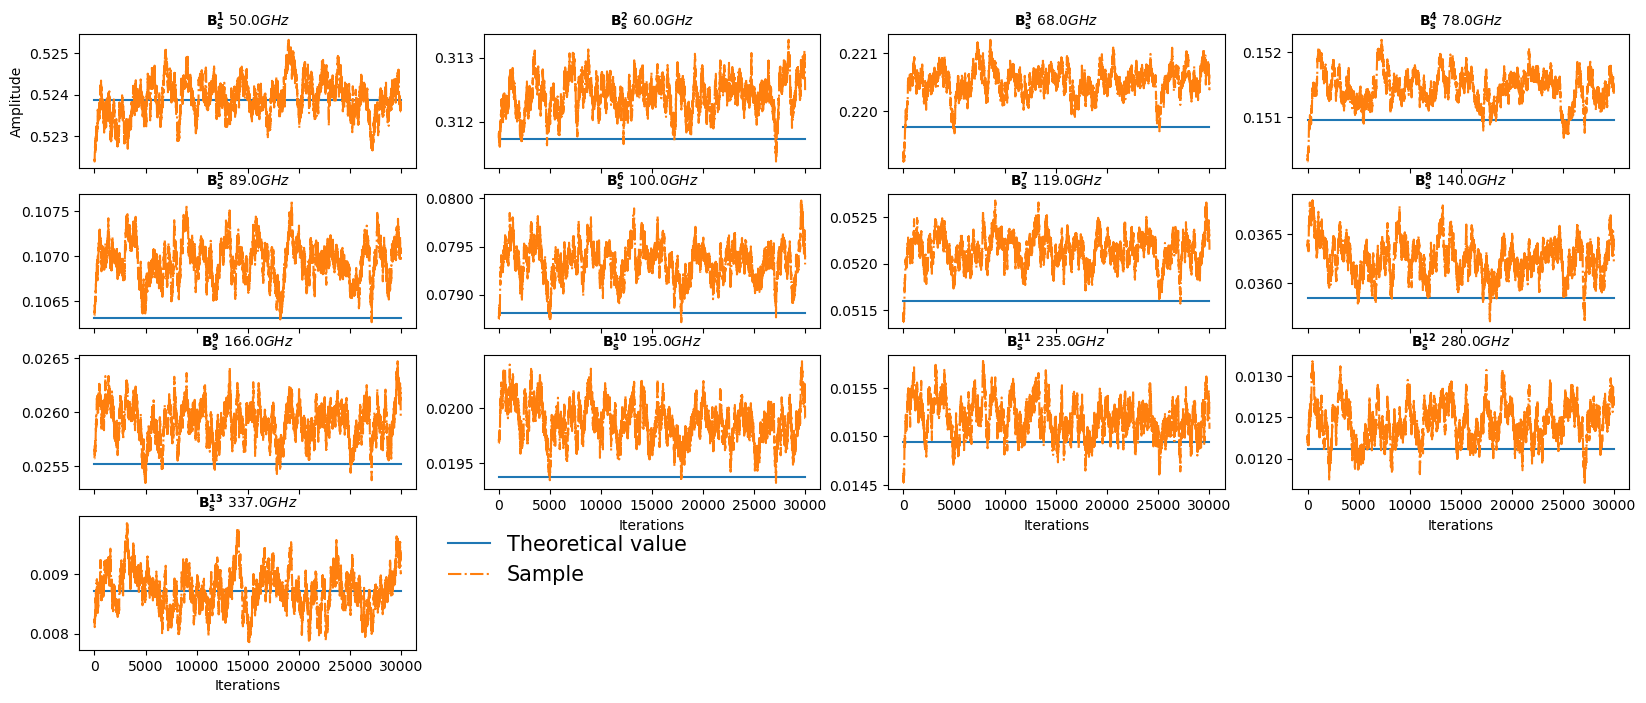

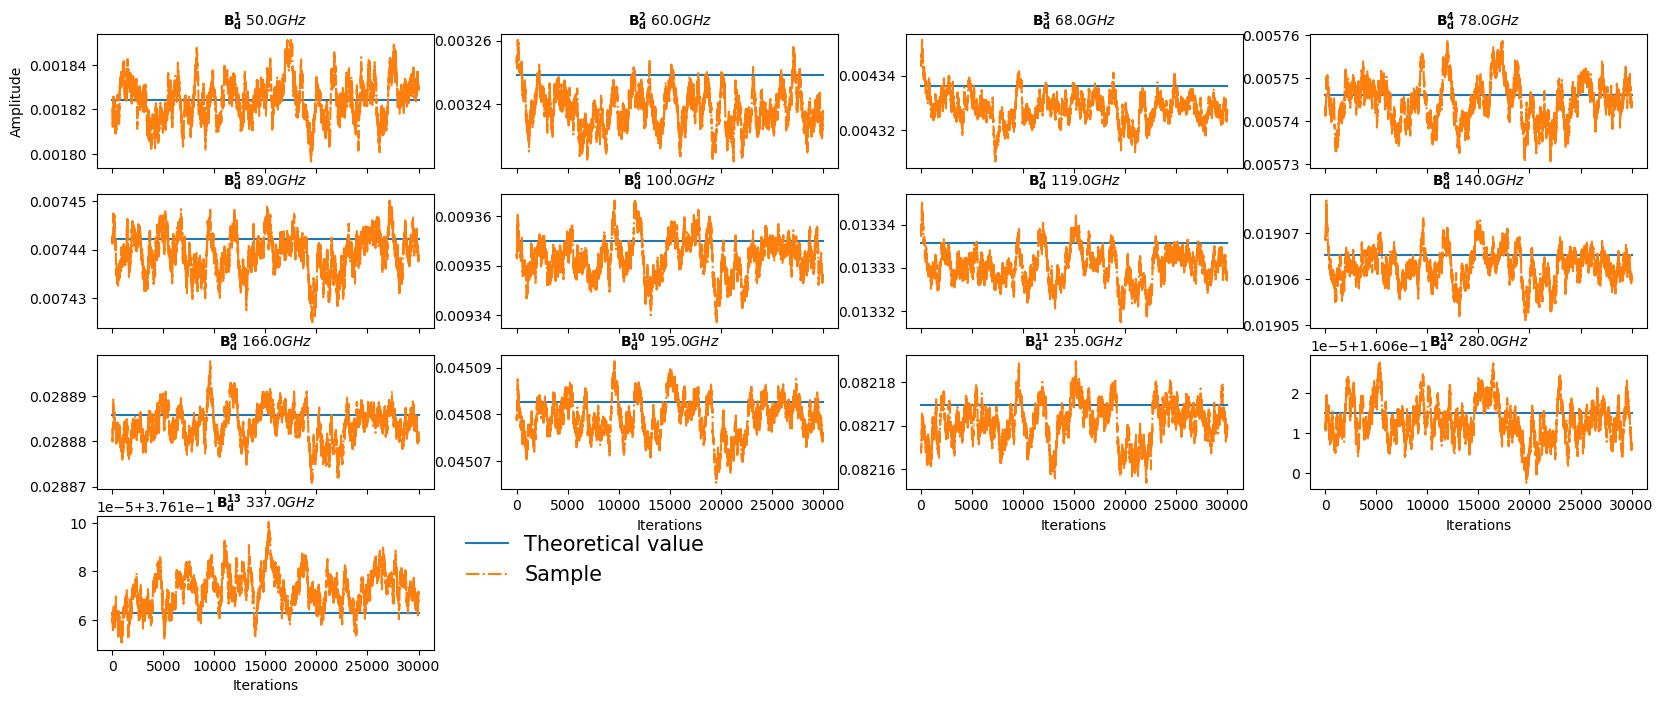

In [26]:
list_correl = ['EE', 'BB', 'EB']

red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)
ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = len(frequency_Bf)
dim_synch = Harm_obj.indexes_b[0,1]
len_pos_special_freqs = len(Harm_obj.pos_special_freqs)


all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:dim_synch]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,dim_synch:]

frequency_array = np.array(instrument['frequency'])

n_columns = 4
number_rows = (Harm_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

fontsize_titles = 10
fontsize_label = 10

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

# fig.suptitle(f"Mixing matrix first component parameters sampled vs iterations", fontsize=14)

for i in range(Harm_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    # ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
    ax[num_row, num_col].set_title('$\mathbf{B_s^{'+f'{i+1}'+'}\ }$' + f'${frequency_Bf[i]} GHz$', fontsize=fontsize_titles, fontdict=dict(weight='bold'))
    
    ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [theoretical_params[i],theoretical_params[i]], label='Theoretical value')
    ax[num_row, num_col].plot(np.arange(Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample')

    cond = np.where(np.arange(Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_synch[cond,i][cond].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_synch[cond,i][cond].std(), decimals=5)

    mean_value = all_B_f_sample_synch[:,i].mean()
    # ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')

    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude', fontsize=fontsize_label)
    if i >= Harm_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations', fontsize=fontsize_label)
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

# fig.suptitle(f"Mixing matrix second component parameters sampled vs iterations", fontsize=14)    
for i in range(Harm_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    # ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
    ax[num_row, num_col].set_title('$\mathbf{B_d^{'+f'{i+1}'+'}\ }$' + f'${frequency_Bf[i]} GHz$', fontsize=fontsize_titles, fontdict=dict(weight='bold'))
    
    ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [theoretical_params[i+dim_synch],theoretical_params[i+dim_synch]], label='Theoretical value')
    ax[num_row, num_col].plot(np.arange(Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample')

    cond = np.where(np.arange(Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_dust[cond,i].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_dust[cond,i].std(), decimals=5)

    mean_value = all_B_f_sample_dust[:,i].mean()
    # ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')
    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude', fontsize=fontsize_label)
    if i >= Harm_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations', fontsize=fontsize_label)
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

And the corresponding histograms, a good test to check if the distribution is Gaussian or not

In [27]:
burn_in = -30000 # To be fine-tuned

bins_number = 25

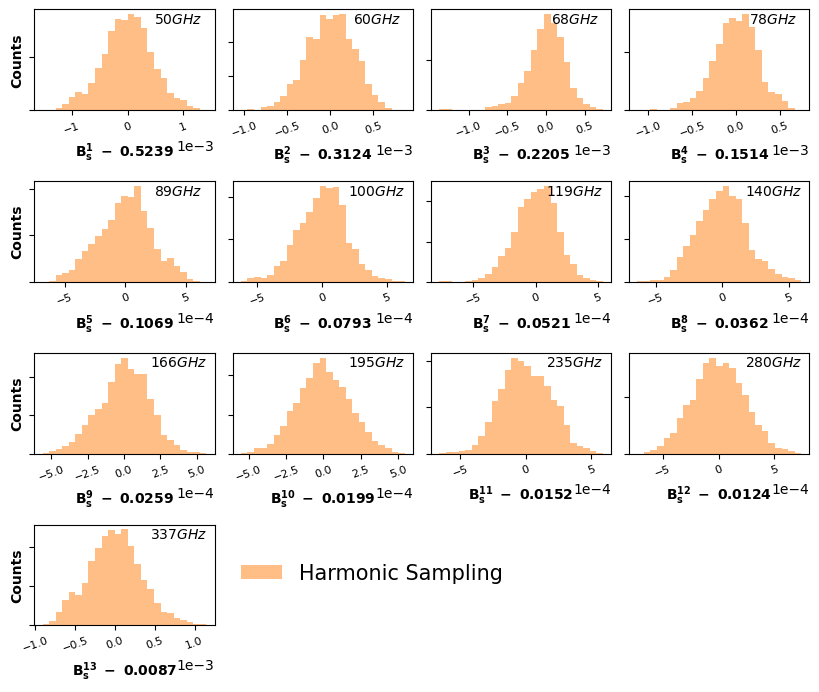

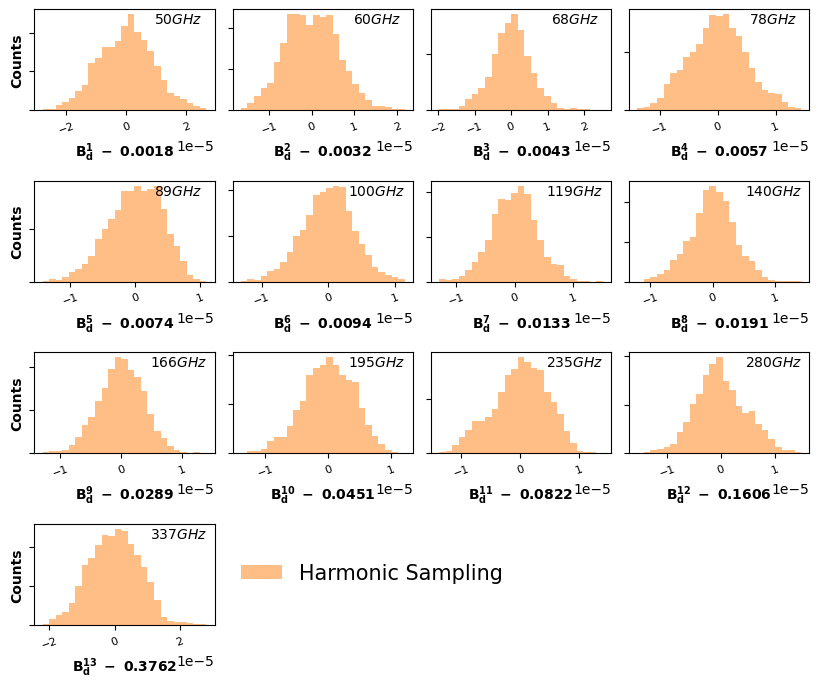

In [28]:
list_correl = ['EE', 'BB', 'EB']

frequency_Bf = np.array(Harm_obj.frequency_array[1:-1])
dimension_free_param_B_f = 2*(Harm_obj.n_frequencies-len_pos_special_freqs)
dim_freq_B_f = len(frequency_Bf)

alpha_value = .5
Harm_color = ['tab:orange']

fontsize_titles = 10
fontsize_label = 10

mean_Harm_synch = Harm_obj.all_params_mixing_matrix_samples[burn_in:,:dim_freq_B_f].mean(axis=0)
mean_Harm_dust = Harm_obj.all_params_mixing_matrix_samples[burn_in:,dim_freq_B_f:].mean(axis=0)

all_B_f_sample_synch = Harm_obj.all_params_mixing_matrix_samples[burn_in:,:dim_freq_B_f] - mean_Harm_synch
all_B_f_sample_dust = Harm_obj.all_params_mixing_matrix_samples[burn_in:,dim_freq_B_f:] - mean_Harm_dust


frequency_array = np.array(Harm_obj.frequency_array)

if Harm_obj.n_frequencies-len_pos_special_freqs >= 10:
    number_columns = 4
    number_rows = (Harm_obj.n_frequencies-len_pos_special_freqs)//number_columns + 1

    fig, ax = plt.subplots(number_rows, number_columns, figsize=(10,8))
    plt.subplots_adjust(hspace=.7, wspace=.1)
    useless_plots = number_rows*number_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
    for idx_useless in range(0,useless_plots):
        num_row = (number_rows*number_columns)//number_columns
        num_col = (number_rows*number_columns)%number_columns
        fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

    for i in range(Harm_obj.n_frequencies-len_pos_special_freqs):
        num_row = i//number_columns
        num_col = i%number_columns
        ax[num_row, num_col].text(.8, .9, f'${frequency_Bf[i]} GHz$', 
                                horizontalalignment='center', 
                                verticalalignment='center', 
                                fontsize=fontsize_titles, 
                                transform=ax[num_row, num_col].transAxes)
        ax[num_row, num_col].xaxis.set_tick_params(labelsize=8)
        ax[num_row, num_col].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        plt.setp(ax[num_row, num_col].get_xticklabels(), rotation=20, horizontalalignment='center')
        
        hist_values, bins_value, _ = ax[num_row, num_col].hist(all_B_f_sample_synch[:,i], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value, label='Harmonic Sampling')

        if num_col == 0:
            ax[num_row, num_col].set_ylabel('Counts', fontsize=fontsize_label, fontdict=dict(weight='bold'))
        ax[num_row, num_col].tick_params(axis='y', labelleft=False)
        
        ax[num_row, num_col].set_xlabel('$\mathbf{B_s^{'+f'{i+1}'+'}\ -}$'+' {:.4f}'.format(mean_Harm_synch[i]), fontsize=fontsize_label, fontdict=dict(weight='bold'))
    ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    fig, ax = plt.subplots(number_rows, number_columns, figsize=(10,8))
    plt.subplots_adjust(hspace=.7, wspace=.1)
    useless_plots = number_rows*number_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
    for idx_useless in range(0,useless_plots):
        num_row = (number_rows*number_columns)//number_columns
        num_col = (number_rows*number_columns)%number_columns
        fig.delaxes(ax[num_row-1, num_col-idx_useless-1])
    
    for i in range(Harm_obj.n_frequencies-len_pos_special_freqs):
        num_row = i//number_columns
        num_col = i%number_columns
        ax[num_row, num_col].text(.8, .9, f'${frequency_Bf[i]} GHz$', 
                                horizontalalignment='center', 
                                verticalalignment='center', 
                                fontsize=fontsize_titles, 
                                transform=ax[num_row, num_col].transAxes)
        ax[num_row, num_col].xaxis.set_tick_params(labelsize=8)
        ax[num_row, num_col].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        plt.setp(ax[num_row, num_col].get_xticklabels(), rotation=20, horizontalalignment='center')

        hist_values, bins_value, _ = ax[num_row, num_col].hist(all_B_f_sample_dust[:,i], bins=bins_number, density=True, color=Harm_color[0], alpha=alpha_value, label='Harmonic Sampling')

        if num_col == 0:
            ax[num_row, num_col].set_ylabel('Counts', fontsize=fontsize_label, fontdict=dict(weight='bold'))
        ax[num_row, num_col].tick_params(axis='y', labelleft=False)

        ax[num_row, num_col].set_xlabel('$\mathbf{B_d^{'+f'{i+1}'+'}\ -} $'+' {:.4f}'.format(mean_Harm_dust[i]), fontsize=fontsize_label, fontweight='bold')
        
    ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 0.8), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

plt.show()

The final values will be given by the average of the chains

In [29]:
last_samples_to_take = 10000 # Last samples to take for the mean and std computation -- To fine-tune

# Getting <B_f>
final_B_f = all_params_mixing_matrix_samples[-last_samples_to_take:,:].mean(axis=0)

# Getting <r>
final_r = all_r_samples[-last_samples_to_take:].mean()

Then we can plot the corresponding residuals

In [30]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total + Harm_obj.r_true*theoretical_red_cov_r1_tensor)
c_ell_CMB_r2 = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total + 0.01*theoretical_red_cov_r1_tensor)
c_ell_lensing = micmac.get_c_ells_from_red_covariance_matrix_JAX(theoretical_red_cov_r0_total)

In [31]:

mean_params_list = [final_B_f]
method_name = ['Harmonic']


Values pixel res fgs: mean 0.001388342728361142 std 0.002159539144143462 max 0.05277580593007514


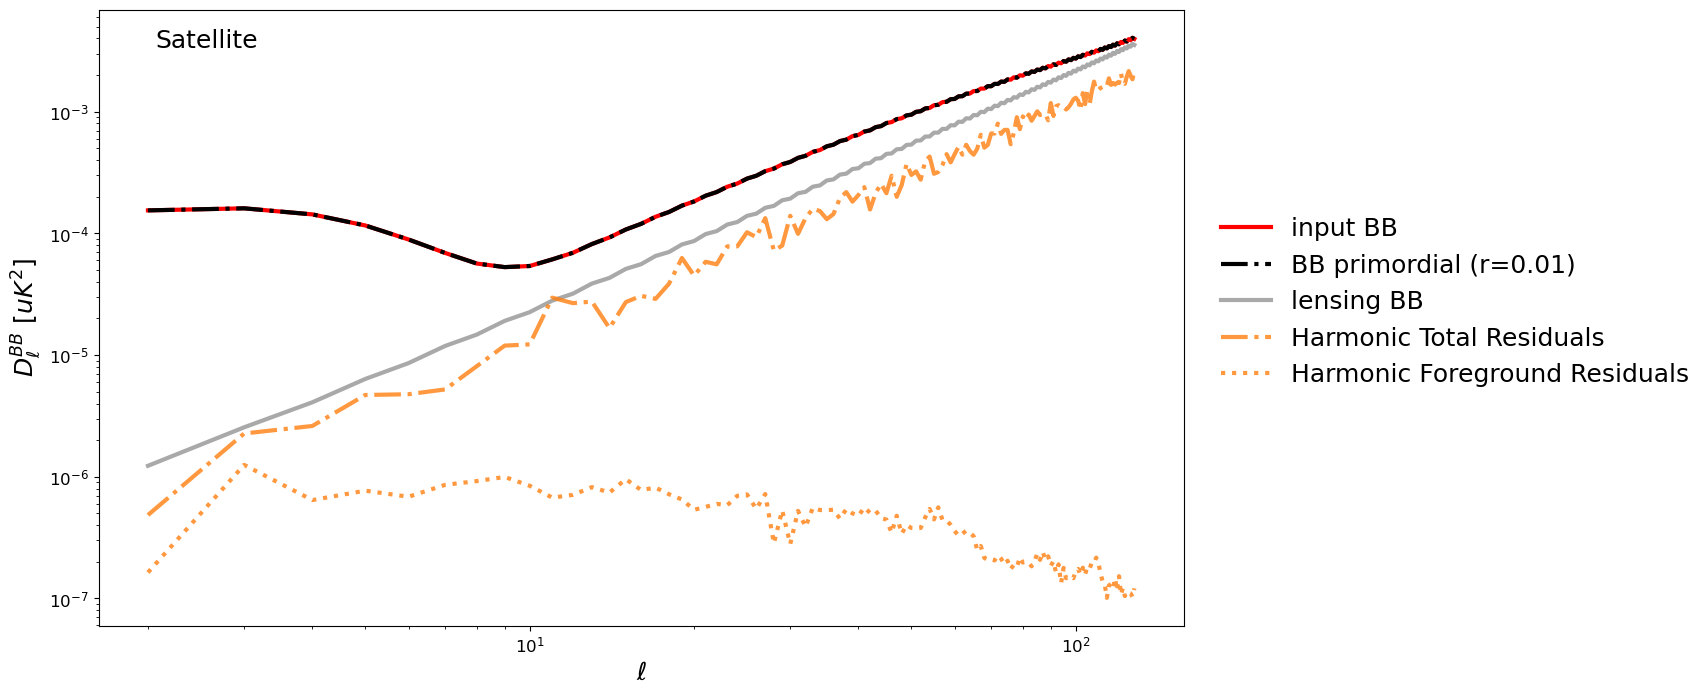

In [32]:
# Residuals power spectrum


colorstyle_list = ['tab:orange','tab:blue','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

indices_polar = np.array([1,2,4])

linewidth_plots = 3

fig, axes = plt.subplots(figsize=(14,8))

ell_array = np.arange(Harm_obj.lmin, Harm_obj.lmax+1)

# Plotting as D_ell = ell*(ell+1)/(2*pi) C_ell
factor_ell = (ell_array*(ell_array+1))/(2*np.pi)

# Plotting the CMB power spectra for reference
plt.plot(ell_array, c_ell_true_CMB[1,:]*factor_ell, color='red', linewidth=linewidth_plots, label='input BB')
plt.plot(ell_array, c_ell_CMB_r2[1,:]*factor_ell, 'k-.', linewidth=linewidth_plots, label='BB primordial (r=0.01)')
plt.plot(ell_array, c_ell_lensing[1,:]*factor_ell, color='darkgray', linewidth=linewidth_plots, label='lensing BB')


# Getting N
freq_inverse_noise = micmac.get_noise_covar_extended(np.array(instrument['depth_p']), Harm_obj.nside)

# Getting the residuals
for i in range(len(mean_params_list)):
    mean_mixing_matrix = Harm_obj.get_B_from_params(mean_params_list[i])
    recovered_CMB_Wd_mean = micmac.get_Wd(freq_inverse_noise, 
                                            mean_mixing_matrix, 
                                            (input_freq_maps-input_cmb_maps-input_noise_map), 
                                            jax_use=False)[0, :, :]
    print("Values pixel res fgs: mean", np.abs(recovered_CMB_Wd_mean).mean(), "std", np.abs(recovered_CMB_Wd_mean).std(), "max", np.abs(recovered_CMB_Wd_mean).max())

    recovered_res_wo_CMB_mean = micmac.get_Wd(freq_inverse_noise, 
                                                mean_mixing_matrix, 
                                                input_freq_maps, 
                                                jax_use=False)[0, :, :] - input_cmb_maps[0]
    recovered_CMB_Wd_mean_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_mean[0]), recovered_CMB_Wd_mean])
    c_ells_recovered_CMB_Wd_mean = hp.anafast(recovered_CMB_Wd_mean_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[2,Harm_obj.lmin:]#/f_sky
    recovered_res_wo_CMB_mean_extended = np.vstack([np.zeros_like(recovered_res_wo_CMB_mean[0]), recovered_res_wo_CMB_mean])
    c_ells_recovered_res_wo_CMB_mean = hp.anafast(recovered_res_wo_CMB_mean_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[2,Harm_obj.lmin:]#/f_sky

    ell_array = np.arange(c_ells_recovered_CMB_Wd_mean.shape[-1])+Harm_obj.lmin

    factor_ell = (ell_array*(ell_array+1))/(2*np.pi)


    label_Stat_res = f"{method_name[i]} Total Residuals"
    label_Syst_res = f'{method_name[i]} Foreground Residuals'

    linestyle_dashdotted = '-.'

    plt.plot(ell_array, 
                c_ells_recovered_res_wo_CMB_mean*factor_ell,
                linestyle=linestyle_dashdotted,
                linewidth=linewidth_plots,
                color=colorstyle_list[i], 
                label=label_Stat_res, alpha=.8)

    linestyle_dotted = ':'

    plt.plot(ell_array, 
                c_ells_recovered_CMB_Wd_mean*factor_ell, 
                linestyle=linestyle_dotted,
                linewidth=linewidth_plots, 
                color=colorstyle_list[i], 
                label=label_Syst_res, alpha=.8)

if Harm_obj.instrument_name == 'LiteBIRD':
    plt.loglog()
else:
    plt.yscale('log')

plt.ylabel("$D^{BB}_\ell$ [$uK^2$]",fontsize=18)
plt.xlabel(r"$\ell$",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Cosmetic putting "Satellite" in the top left corner
plt.text(.1, .95, 'Satellite', 
                        horizontalalignment='center', 
                        verticalalignment='center', 
                        fontsize=18, 
                        transform=axes.transAxes)

plt.legend(bbox_to_anchor=(1.25, .7), loc='upper center', prop={'size': 18}, frameon=False)
plt.show()
